# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 -1
  1
 -1
 -1
 -1
 -1
 -1
  1
  1

### We create a function to visualize the data

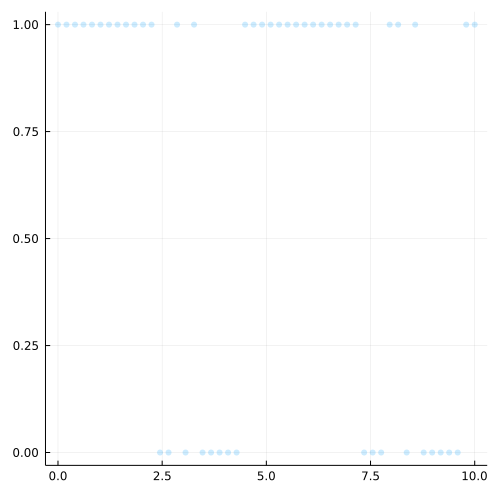

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.055032 seconds (1.85 M allocations: 98.357 MiB, 99.64% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.4520129709500091, 1.5702525272562555, 1.6767104941597117, 1.758256900769462, 1.803204593975892, 1.8024470369874053, 1.750335751161831, 1.645388778843332, 1.49093213266004, 1.29586294887052  …  0.68481480161746, 0.7439791926087443, 0.7922905278522273, 0.8203572522749446, 0.8231173977971992, 0.8017695341061875, 0.7651602039485517, 0.7297994858885739, 0.7149261679361104, 0.732107412710738], θ = [0.21370886147236148, 0.20876871672101632, 0.20425020062785862, 0.2007620244469884, 0.19883411004478715, 0.19886662019049717, 0.20110149996339224, 0.20558475950561525, 0.2120942546238375, 0.22003708111671502  …  0.2406672026536927, 0.23907306052945346, 0.23769429645728404, 0.23686286559740127, 0.23677992552894142, 0.2374159483892913, 0.23847688240731185, 0.23946477488372636, 0.23986917165570643, 0

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:27
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:47
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:51
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:23
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:06
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:55
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:47
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.0416728227095271, -0.07737278839209316, 0.001834313182450531, 0.15955926520595254, 0.3858215208008151, 0.7035831692381067, 1.0409112289667148, 1.3762043153180907, 1.664658259913332, 1.851327159870956  …  -0.7392657630687174, -0.6015020029510598, -0.3813742569503603, -0.18433167460123784, 0.021262513927699622, 0.19464273853339203, 0.3294536953495496, 0.44867912249924263, 0.5647267340815765, 0.7026100166068565]]
 [[1.349272758460285, 1.3711888560788146, 1.3066942427966204, 1.121266764130981, 0.8489319696001021, 0.46846348155361306, 0.028913678386912167, -0.3669271757508341, -0.7131213530398621, -0.9537775008395806  …  -1.455431868518637, -1.6682206770578514, -1.6976579009405068, -1.5408355524005657, -1.2183048572406028, -0.7995765242201416, -0.3930943347996593, -0.0355715652796782, 0.17902146884835468, 0.2426875134046937]]
 [[0.17602240953091564, 0.31932930062603504, 0.5257471980166122, 0.8239120369061007, 1.1425519593983966, 1.42985058

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

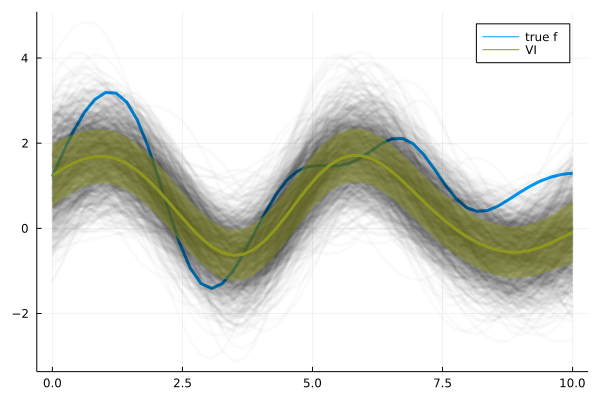

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

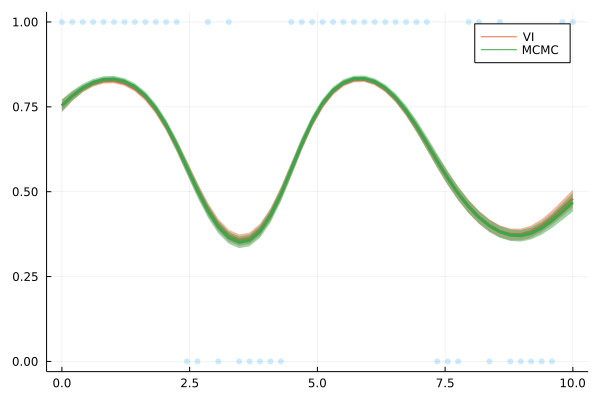

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*